In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Normalization, CategoryEncoding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import warnings
import joblib
import shap
from IPython.display import display
from sklearn.metrics import mean_absolute_error

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


/Users/jr/.pyenv/versions/3.11.9/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X_train = train_df.drop('Y', axis=1)
y_train = train_df['Y']
X_test = test_df.drop('Y', axis=1)
y_test = test_df['Y']

X_train.shape[1]
X_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,20.236432,67.523185,35.766385,68.459483,74.946516,89.632851,78.277026,116.827922,122.975621,DEB
1,10.551182,57.675655,51.525733,49.891951,113.074296,81.223638,74.534979,92.063753,114.186779,AED
2,14.069105,33.115667,60.014587,48.412263,88.815278,128.651604,79.616572,145.231095,122.473611,DAF
3,15.537824,28.032600,68.797017,55.482058,59.269249,103.644283,77.766831,135.170297,145.037862,ACV
4,10.791858,46.429463,48.373435,41.870487,101.306253,119.684299,75.929410,103.408770,140.392891,DAF


In [3]:
print(X_train['X10'].nunique())

6


In [4]:
# TODO: automatically infer from column dtype

numeric_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'] 
categorical_cols = ['X10']


normalizer = Normalization()
normalizer.adapt(np.array(X_train[numeric_cols])) 

categories = X_train['X10'].unique()
cat_mapping = {cat: i for i, cat in enumerate(categories)}

X_train['X10_encoded'] = X_train['X10'].map(cat_mapping)
X_test['X10_encoded'] = X_test['X10'].map(cat_mapping)

# Save the mapping for inference
joblib.dump(cat_mapping, 'categorical_mapping.joblib')

one_hot_encoder = CategoryEncoding(num_tokens=len(cat_mapping), output_mode="one_hot")

numeric_inputs = tf.keras.Input(shape=(len(numeric_cols),), name="numeric_inputs")
categorical_inputs = tf.keras.Input(shape=(1,), name="categorical_inputs")

numeric_preprocessed = normalizer(numeric_inputs)
categorical_preprocessed = one_hot_encoder(categorical_inputs)

concatenated_inputs = tf.keras.layers.Concatenate()([numeric_preprocessed, categorical_preprocessed])


2025-03-30 17:43:34.847384: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-30 17:43:34.847414: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-30 17:43:34.847419: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1743317014.847435 8276507 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743317014.847453 8276507 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Note: we can't use sequential() as this only works when layers are stacked in a single flow, but we are concatenating the inputs

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(concatenated_inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(concatenated_inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
output = tf.keras.layers.Dense(1, kernel_regularizer=regularizers.l2(1e-4))(x)

model = tf.keras.Model(inputs=[numeric_inputs, categorical_inputs], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_absolute_error')

model.summary()
    

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numeric_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_inputs  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 9)         │         19 │ numeric_inputs[0… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding   │ (None, 6)         │          0 │ categorical_inpu… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 15)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ category_encodin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         17 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,844 (54.08 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 467 (1.83 KB)

In [6]:
history = model.fit(
    {
        "numeric_inputs": X_train[numeric_cols].values,
        "categorical_inputs": X_train['X10_encoded'].values.reshape(-1, 1)
    },
    y_train,
    validation_data=(
        {
            "numeric_inputs": X_test[numeric_cols].values,
            "categorical_inputs": X_test['X10_encoded'].values.reshape(-1, 1)
        },
        y_test
    ),
    epochs=100,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]
)


model.save('dius_model.keras')


Epoch 1/100


2025-03-30 17:43:35.538151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 868.6161 - val_loss: 858.6893
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 841.4805 - val_loss: 695.5295
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 698.8553 - val_loss: 657.0896
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 535.9722 - val_loss: 193.5992
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 100.3418 - val_loss: 54.8105
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 30.9766 - val_loss: 35.8903
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 25.2077 - val_loss: 26.5406
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 24.3486 - val_loss: 24.3126
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 23.6433 - val_loss: 16.4766
Epoch 10/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 22.2004 - val_loss: 21.4478
Epoch 11/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 22.5649 - val_loss: 29.0175
Epoch 12/10

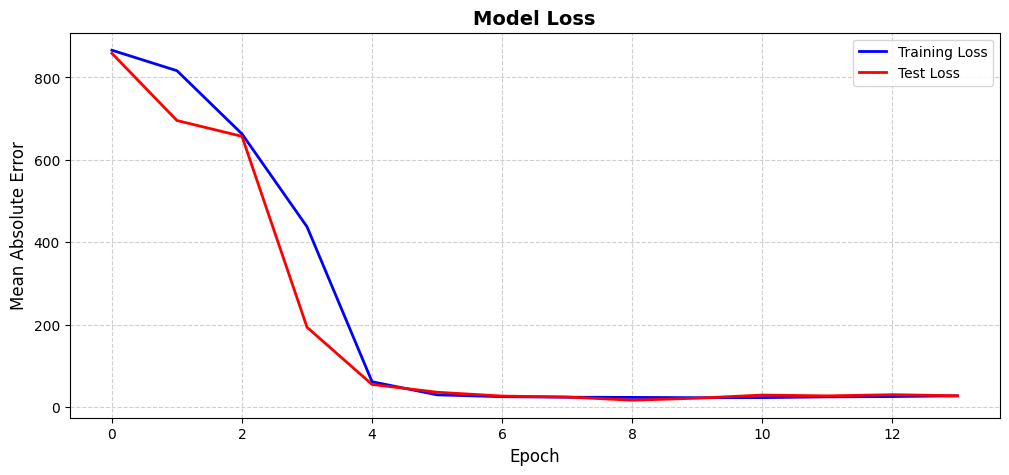

In [7]:
plt.figure(figsize=(12, 5))
    
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Test Loss', color='red', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')

plt.show()

## Feature Significance
We use the `shap` values to compute feature significance

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:27<00:00,  7.19it/s]


Feature Importance Ranking:


,Feature,Importance
9,X10,23.092042
1,X2,11.004163
6,X7,9.667246
7,X8,8.323319
8,X9,6.640596
3,X4,2.675145
5,X6,2.262542
4,X5,2.073486
2,X3,1.642158
0,X1,0.776476


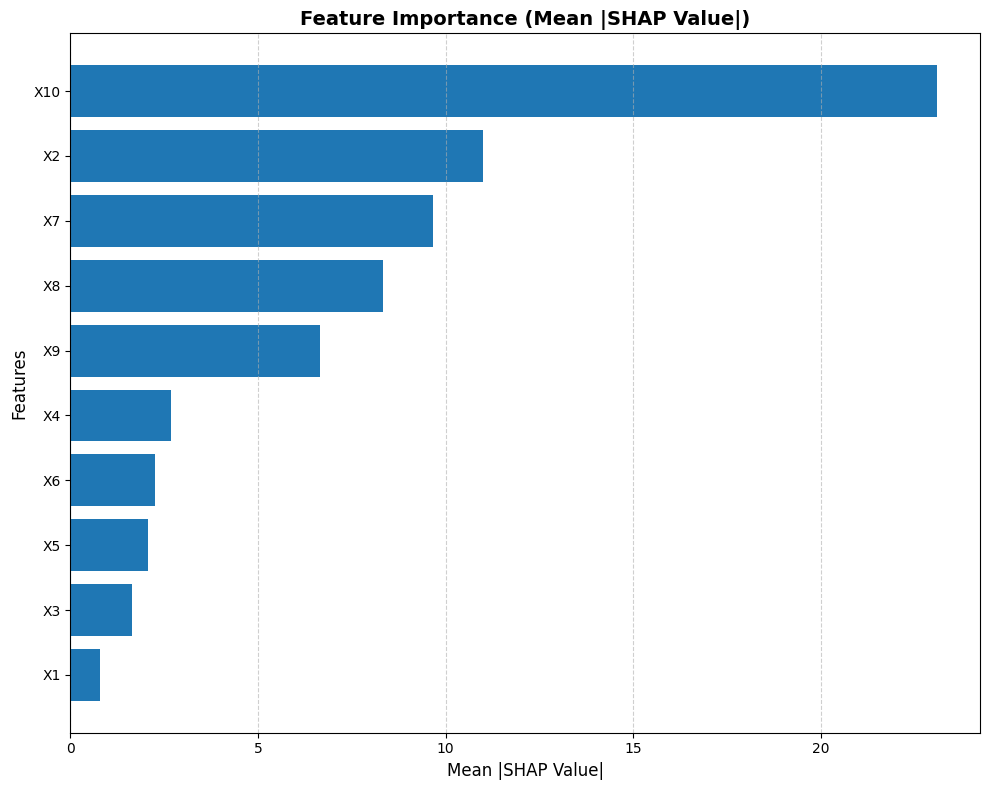

In [8]:

# wrapper function for the model that takes a single input
def f(x):
    return model({
        "numeric_inputs": x[:, :len(numeric_cols)],
        "categorical_inputs": x[:, len(numeric_cols):].reshape(-1, 1)
    })

# subset for efficiency
background_data = np.hstack([
    X_train[numeric_cols].values[:1000],
    X_train['X10_encoded'].values.reshape(-1, 1)[:1000]
])

explainer = shap.KernelExplainer(f, background_data)

# subset the test data for efficiency
test_data = np.hstack([
    X_test[numeric_cols].values[:200],
    X_test['X10_encoded'].values.reshape(-1, 1)[:200]
])
shap_values = explainer.shap_values(test_data)


if isinstance(shap_values, list):
    shap_values = shap_values[0]

feature_names = numeric_cols + ['X10']

feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance.flatten() if feature_importance.ndim > 1 else feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
display(importance_df)

importance_df = importance_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance (Mean |SHAP Value|)', fontsize=14, fontweight='bold')
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()



## Model Evaluation and Inference

In [9]:

# Check for any values in X_test['X10'] that are not in the mapping
unknown_categories = X_test['X10'].isin(cat_mapping.keys()) == False
if unknown_categories.any():
    print(f"Warning: Found {unknown_categories.sum()} unknown categories in test data.")
    print(f"Unknown categories: {X_test.loc[unknown_categories, 'X10'].unique()}")
    default_category = next(iter(cat_mapping.values()))
    X_test['X10_encoded_safe'] = X_test['X10'].apply(lambda x: cat_mapping.get(x, default_category))
else:
    X_test['X10_encoded_safe'] = X_test['X10_encoded']

y_pred = model.predict({
    "numeric_inputs": X_test[numeric_cols].values,
    "categorical_inputs": X_test['X10_encoded_safe'].values.reshape(-1, 1)
})

test_df['prediction'] = y_pred
test_df.to_csv('test_pred.csv')

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on test data: {mae:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Absolute Error (MAE) on test data: 16.1138


In [10]:
test_df[['Y', 'prediction']].head(10)

,Y,prediction
0,869.139112,860.957581
1,734.205759,726.909790
2,917.225510,904.169495
3,870.848264,868.091736
4,785.683850,791.273865
5,922.762069,885.464844
6,854.582706,865.744934
7,866.039361,847.810669
8,761.964041,754.853577
9,1066.865530,1039.419434
